In [5]:
from os import putenv
putenv("HSA_OVERRIDE_GFX_VERSION", "10.3.0")

import cv2 as cv  # type: ignore
import numpy as np  # type: ignore
from PIL import Image  # type: ignore
from pyzbar.pyzbar import decode  # type: ignore
from pdf2image import convert_from_path  # type: ignore

from doctr.models import ocr_predictor # type: ignore
from doctr.io import DocumentFile # type: ignore

import re

In [6]:

class DocumentProcessor:
    def __init__(self):
        self.model = ocr_predictor(det_arch='db_mobilenet_v3_large', reco_arch='crnn_vgg16_bn', pretrained=True)

    def get_image(self, pdf):
        images = convert_from_path(pdf)
        return images[0]

    def read_barcode(self, image):
        img = np.array(image)
        img_bgr = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

        detected = decode(img)

        min_width = 10
        min_height = 10

        if not detected:
            print("Barcode Not Detected")
            return None
        else:
            for barcode in detected:
                (x, y, w, h) = barcode.rect

                if w > min_width and h > min_height:
                    cv.rectangle(img_bgr, (x-10, y-10), (x + w + 10, y + h + 10), (255, 0, 0), 2)
                    if barcode.data:
                        barcode_value = barcode.data.decode('utf-8')
                        return barcode_value

        output_filename = 'output.jpeg'
        cv.imwrite(output_filename, img_bgr)
        return None

    def read_identification(self, image):
        img = DocumentFile.from_images(image)
        result = self.model(img)

        word_values = []
        for page in result.pages:
            for block in page.blocks:
                for line in block.lines:
                    for word in line.words:
                        word_values.append(word.value)

        return word_values

    def regex_parser(self, words):
        valid = []
        pattern = r'/([^/,]+)/'

        for word in words:
            matches = re.findall(pattern, word)
            if matches:
                valid.extend(matches)

        return valid

    def make_dict(self, barcode, text):
        return {barcode.strip(): text}

    def view_pdf(self, pdf):
        doc = DocumentFile.from_pdf(pdf)
        result = self.model(doc)
        result.show()


In [8]:
pdf_path = 'test.pdf'
img_path = 'output.jpeg'
    
processor = DocumentProcessor()
    
image = processor.get_image(pdf_path)
    
barcode_result = processor.read_barcode(image)
    
text_result = processor.regex_parser(processor.read_identification(img_path))
    
if barcode_result and text_result:
    print(processor.make_dict(barcode_result, text_result))
else:
    print("Could not process the document.")


/home/smit/Documents/code/Python/OpenCV/venv/lib/python3.12/site-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

{'188833583': ['23323323354', '3288883', '19983333322']}


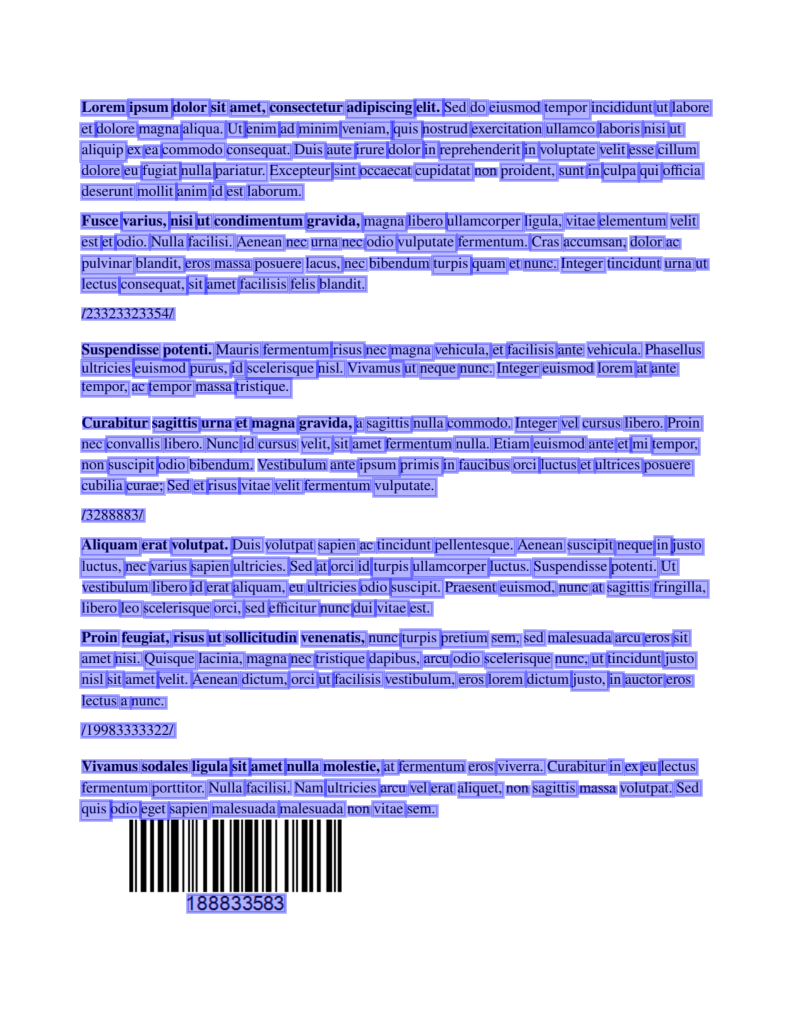

In [9]:
processor.view_pdf(pdf_path)